<a href="https://colab.research.google.com/github/varJATIN/Ocular-fundus-image-Analysis/blob/main/MA_clahe_walter_4_channel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from sklearn.utils import shuffle
from matplotlib.pyplot import imread
from cv2 import resize
import matplotlib.pyplot as plt
import cv2
import scipy
## Seeding 
seed = 2
random.seed = seed
#np.random.seed = seed
tf.seed = seed

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1,drop=0.1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = tf.keras.layers.BatchNormalization()(c)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    c = tf.keras.layers.BatchNormalization()(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    c = keras.layers.Dropout(drop)(c)
    return c, p

def atten(x,g,F_x,F_g,F_int,kernel_size=(3,3), padding="same", strides=1):
    # upsample lower decoder filters
    us = keras.layers.UpSampling2D((2, 2))(g)
    gate = keras.layers.Conv2D(F_g, kernel_size, padding=padding, strides=strides, activation="relu")(us)
    gate=tf.keras.layers.BatchNormalization()(gate)
    
    # convolve the upsampled decoder filter for F_int filters
    W_g=keras.layers.Conv2D(F_int, kernel_size=1, padding=padding, strides=strides)(gate)
    W_g=tf.keras.layers.BatchNormalization()(W_g)
    
    # convolve encoder output for F_int filters
    W_x=keras.layers.Conv2D(F_int, kernel_size=1, padding=padding, strides=strides)(x)
    W_x=tf.keras.layers.BatchNormalization()(W_x)
    
    # convolve to  attention filter
    psi=tf.keras.activations.relu(W_x+W_g, alpha=0.0, max_value=None, threshold=0)
    psi=keras.layers.Conv2D(F_x, kernel_size=1, padding=padding, strides=strides)(psi)
    psi=tf.keras.activations.sigmoid(tf.keras.layers.BatchNormalization()(psi))
    
    # return the filtered encoder output for concat
    return x*psi

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1,drop=0.1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    us = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(us)
    us = tf.keras.layers.BatchNormalization()(us)
    # here skip is from encoder and x if from dec previous layer 
    filtered_skip=atten(skip,x,filters,filters,filters/2)
    #concat filtrd skip and upsampled us
    concat = keras.layers.Concatenate()([us, filtered_skip])
    #c = keras.layers.Dropout(drop)(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c=tf.keras.layers.BatchNormalization()(c)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    c=tf.keras.layers.BatchNormalization()(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c=tf.keras.layers.BatchNormalization()(c)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    c=tf.keras.layers.BatchNormalization()(c) 
    return c

In [4]:
def UNet_modular(depth=4,f=3,image_size=512):
    """ returns a modular code for the UNet multihead attention with
        deep supervision.
        depth is depth of model excluding bottleneck.
        f is no of filters in first layer.
        image_size is image pixel 
    """
    # define input container with 3 input channels
    input_channels=4
    inputs= keras.layers.Input((image_size, image_size, input_channels))
    pooled_out=inputs
    skip_memory=[]
    filters=[]
    for layer in range(depth):
      filters.append(f*2**layer)
    print(filters)

    for layer in range(depth):
      x,pooled_out=down_block(pooled_out,filters[layer])
      skip_memory.append(x)	

    # bottleneck_factor 
    bn_factor=2**depth
    upsample_out=bottleneck(pooled_out,f*bn_factor)
    upsample_memory=[upsample_out]
    for layer in range(depth):
      upsample_out=up_block(upsample_out,skip_memory[depth-1-layer],filters[depth-1-layer])
      upsample_memory.append(upsample_out)

    #up sample layer
    up=keras.layers.UpSampling2D((2,2))
    #create empty list for storing skip up samples 
    skip_up_list=[]
    # upsample the outputs of upsample layers stored in upsample_memory
    for i in range(depth):
      skip_up=upsample_memory[i]
      for j in range(depth-i):
        skip_up=up(skip_up)
      skip_up_list.append(skip_up)
    skip_up_list.append(upsample_memory[depth])
    deep_supervised = keras.layers.Concatenate()(skip_up_list)
    outputs=keras.layers.Conv2D(1,(1,1),padding="same",activation="sigmoid")(deep_supervised)
    model=keras.models.Model(inputs,outputs)
    return model

In [5]:
# data
data_location = "/content/drive/My Drive/IDRid/A. Segmentation/1. Original Images/a. Training Set"
train_data = []  # create an empty list
for (dirName, subdirList, fileList) in sorted(os.walk(data_location)):
    for fileName in sorted(fileList):
        if ".jpg" in fileName.lower() :
            train_data.append(os.path.join(dirName,fileName))
 
print(len(train_data))

# groundtruths for hard exudates
target_root_location = "/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/"
#data_location = "/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/3. Hard Exudates"
train_data_gt = []  # create an empty list
segs=['1. Microaneurysms','2. Haemorrhages','3. Hard Exudates','4. Soft Exudates']
for seg in segs:
  data_location=target_root_location+seg
  print(data_location)
  seg_mask=[]
  for dirName, subdirList, fileList in sorted(os.walk(data_location)):
      for filename in sorted(fileList):
          if ".tif" in filename.lower() :
              seg_mask.append(os.path.join(dirName,filename))
              #train_data_gt.append(os.path.join(dirName,filename))
  train_data_gt.append(seg_mask)
print(len(train_data_gt));

54
/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/1. Microaneurysms
/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/2. Haemorrhages
/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/3. Hard Exudates
/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/4. Soft Exudates
4


In [6]:
train_batch = np.zeros(shape = (len(train_data)*5, 640,640, 4));
train_label = np.zeros(shape = (len(train_data)*5, 640,640, 1));
rot=[-4,-3,-2,-1,1,2,3,4]
for file_index in range(0,len(train_data)*5,5):
    #print(file_index)
    # image
    img=(imread(train_data[int(file_index/5)]))#/255
    eye_mask=img[:,:,1]<8
    eye=np.ones((2848, 4288))
    eye[eye_mask]=0
    del eye_mask
    #normalize green channel
    G = img[:, :, 1]/255
    square_size =int(25/536 * G.shape[1])
    uw = cv2.blur(G, (square_size, square_size))
    Iw = np.zeros((uw.shape[0], uw.shape[1]))
    mask = G <= uw
    #min max value of normalized channel
    max_Gr_ch= np.max(img[:,:,1])/255#np.max(img[:,:,1])
    min_Gr_ch= np.min(img[:,:,1])/255#np.max(img[:,:,1])
    int_mask=np.zeros((uw.shape[0], uw.shape[1]))
    int_mask[mask]=1
    #desired min max levels
    u_min=0
    u_max=1
    #fill greater at place where uw(mean image) is more then orginal 
    greater= 0.5*(u_max-u_min)*(G-min_Gr_ch)**2/(uw-min_Gr_ch)**2+u_min
    #fill lesser at place where uw is less then orginal
    lesser= -0.5*(u_max-u_min)*(G-max_Gr_ch)**2/(uw-max_Gr_ch)**2+u_max
    Iw+=(int_mask)*greater
    Iw+=(1-int_mask)*lesser
    Iw=np.clip(Iw,0,1)
    nan_mask=np.isnan(Iw)
    #replacing with 0 as nan can occur when uw is 0 not 1 becuase uw can not be 1 here mostly
    Iw[nan_mask]=0
    Iw=Iw*eye
    del nan_mask,mask,int_mask
    #CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl1 = clahe.apply(img[:,:,1])
    g_blur = cv2.GaussianBlur(cl1,(3,3),0)
    
    #g_blur = cv2.GaussianBlur(Iw,(3,3),0)
    train_batch[file_index, :, :,0:3] = resize(img, (640,640))
    train_batch[file_index, :, :,3] = resize(Iw, (640, 640))
    train_batch[file_index, :, :,1] = resize(g_blur, (640, 640))
    # label
    img = cv2.cvtColor(imread(train_data_gt[0][int(file_index/5)]), cv2.COLOR_BGRA2BGR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    train_label[file_index, :, :,:] = np.expand_dims(resize(img, (640,640)), axis = 2)
    #print(np.max(train_batch),np.max(train_label))
    #flip
    train_batch[file_index+1, :, :,:]=np.flip(train_batch[file_index, :, :,:],axis=1)
    train_label[file_index+1, :, :,:]=np.flip(train_label[file_index, :, :,:],axis=1)
    #flip
    train_batch[file_index+2, :, :,:]=np.flip(train_batch[file_index, :, :,:],axis=0)
    train_label[file_index+2, :, :,:]=np.flip(train_label[file_index, :, :,:],axis=0)
    #rotate
    train_batch[file_index+3, :, :,:]=np.rot90(np.rot90(train_batch[file_index, :, :,:]))
    train_label[file_index+3, :, :,:]=np.rot90(np.rot90(train_label[file_index, :, :,:]))

    #random rotate
    ang=random.choice(rot)
    train_batch[file_index+4, :, :,:]=scipy.ndimage.rotate(train_batch[file_index, :, :,:],ang,reshape=False)
    train_label[file_index+4, :, :,:]=scipy.ndimage.rotate(train_label[file_index, :, :,:],ang,reshape=False)


train_batch[:,:,:,0]  = (train_batch[:,:,:,0])/np.max(train_batch)# - train_batch[:,:,:,0].min(axis=0)) / (train_batch[:,:,:,0].max(axis=0) - train_batch[:,:,:,0].min(axis=0)+1e-10)
train_batch[:,:,:,1]  = (train_batch[:,:,:,1])/np.max(train_batch)# - train_batch[:,:,:,1].min(axis=0)) / (train_batch[:,:,:,1].max(axis=0) - train_batch[:,:,:,1].min(axis=0)+1e-10)
train_batch[:,:,:,2]  = (train_batch[:,:,:,2])/np.max(train_batch)# - train_batch[:,:,:,2].min(axis=0)) / (train_batch[:,:,:,2].max(axis=0) - train_batch[:,:,:,2].min(axis=0)+1e-10)
train_batch[:,:,:,3]  = (train_batch[:,:,:,3])/np.max(train_batch[:,:,:,3])

train_label[:,:,:,0]  = (train_label[:,:,:,0])/np.max(train_label)# - train_label[:,:,:,0].min(axis=0)) / (train_label[:,:,:,0].max(axis=0) - train_label[:,:,:,0].min(axis=0)+1e-10)
mask = train_label[:,:,:,:] > 0.25
train_label[mask] = 1.0
train_label[~mask] = 0.0

print(train_batch.shape)
print(train_label.shape)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


(270, 640, 640, 4)
(270, 640, 640, 1)


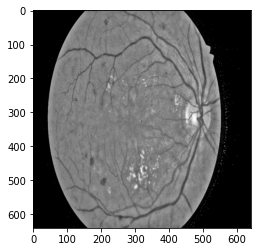

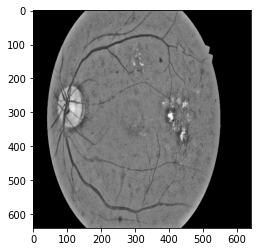

In [7]:
for i in range(0,10,5):
  plt.imshow(train_batch[i,:,:,3],cmap='gray')
  plt.show()

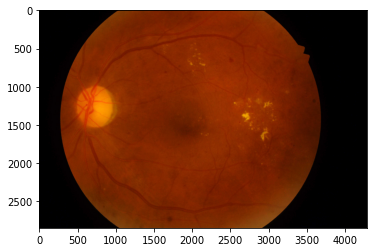

0.9188663011476996


In [8]:
plt.imshow(imread(train_data[1]),cmap='gray')
plt.show()
print(np.max(train_batch[1][:,:,0]))

In [9]:
from keras import backend as K
def dice_loss(y_true, y_pred, smooth=1):
  intersection = K.sum(y_true * y_pred, axis=[1,2,3])
  union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
  dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
  return 1-dice

In [10]:
seed = 2
random.seed = seed
np.random.seed = seed
tf.seed = seed
tf.random.set_seed(2)
depths=[2,3,4]
models=[]
histories=[]
for f in [24]: 
  for depth in [2]:
    opt=keras.optimizers.Adam(learning_rate = 0.001,beta_1=0.5)
    model = UNet_modular(depth=depth,f=f,image_size=640) 
    model.compile(optimizer=opt, loss=dice_loss, metrics=[tf.keras.metrics.MeanIoU(num_classes=2)])   
    early_stopping= tf.keras.callbacks.EarlyStopping(monitor='loss',min_delta	=0.001, patience=8)
    hist = model.fit(x = train_batch, y = train_label, batch_size = 4, epochs = 200, verbose = 1, callbacks=[early_stopping], shuffle = True)
    models.append(model)
    histories.append(hist) 

[24, 48]
Epoch 1/200
68/68 [==============================] - 55s 649ms/step - loss: 0.9912 - mean_io_u: 0.4569
Epoch 2/200
68/68 [==============================] - 44s 643ms/step - loss: 0.9722 - mean_io_u: 0.4173
Epoch 3/200
68/68 [==============================] - 45s 657ms/step - loss: 0.9969 - mean_io_u: 0.3702
Epoch 4/200
68/68 [==============================] - 45s 665ms/step - loss: 0.9794 - mean_io_u: 0.4267
Epoch 5/200
68/68 [==============================] - 46s 674ms/step - loss: 0.8952 - mean_io_u: 0.4537
Epoch 6/200
68/68 [==============================] - 46s 682ms/step - loss: 0.8210 - mean_io_u: 0.4859
Epoch 7/200
68/68 [==============================] - 47s 685ms/step - loss: 0.8506 - mean_io_u: 0.4868
Epoch 8/200
68/68 [==============================] - 47s 691ms/step - loss: 0.7121 - mean_io_u: 0.5644
Epoch 9/200
68/68 [==============================] - 47s 691ms/step - loss: 0.6135 - mean_io_u: 0.5887
Epoch 10/200
68/68 [==============================] - 47s 690ms/

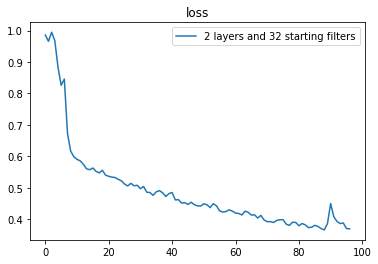

In [11]:
j=0
k=0 
for i,hist in enumerate(histories):
  plt.plot(hist.history['loss'],label="{} layers and {} starting filters".format(2,32))
  j+=1
  if j%3==0:
    j=0
    k+=1
plt.legend()
plt.title('loss')
plt.show()

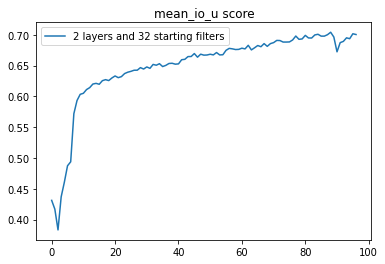

In [12]:
j=0
k=0
for i,hist in enumerate(histories):
  plt.plot(hist.history['mean_io_u'],label="{} layers and {} starting filters".format(2,32))
  j+=1
  if j%3==0:
    j=0
    k+=1
plt.legend()
plt.title('mean_io_u score')
plt.show()

# test data

In [13]:
# data
data_location = "/content/drive/My Drive/IDRid/A. Segmentation/1. Original Images/b. Testing Set"
test_data = []  # create an empty list
for (dirName, subdirList, fileList) in sorted(os.walk(data_location)):
    for fileName in sorted(fileList):
        if ".jpg" in fileName.lower() :
            test_data.append(os.path.join(dirName,fileName))
    
print(len(test_data))
target_root_location = "/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/b. Testing Set/"

test_data_gt = []  # create an empty list
segs=['1. Microaneurysms','2. Haemorrhages','3. Hard Exudates','4. Soft Exudates']
for seg in segs:
  data_location=target_root_location+seg
  print(data_location)
  seg_mask=[]
  for dirName, subdirList, fileList in sorted(os.walk(data_location)):
      for filename in sorted(fileList):
          if ".tif" in filename.lower() :
              seg_mask.append(os.path.join(dirName,filename))
              
  test_data_gt.append(seg_mask)
print(len(test_data_gt));

27
/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/b. Testing Set/1. Microaneurysms
/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/b. Testing Set/2. Haemorrhages
/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/b. Testing Set/3. Hard Exudates
/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/b. Testing Set/4. Soft Exudates
4


In [14]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve,precision_score,recall_score

In [15]:
test_batch = np.zeros(shape = (len(test_data), 640,640, 4));
for file_index in range(0,len(test_data)):
    #print(file_index)
    # image
    img   = imread(test_data[file_index])
    eye_mask=img[:,:,1]<8
    eye=np.ones((2848, 4288))
    eye[eye_mask]=0
    del eye_mask
    #normalize green channel
    G = img[:, :, 1]/255
    square_size =int(25/536 * G.shape[1])
    uw = cv2.blur(G, (square_size, square_size))
    Iw = np.zeros((uw.shape[0], uw.shape[1]))
    mask = G <= uw
    #min max value of normalized channel
    max_Gr_ch= np.max(img[:,:,1])/255#np.max(img[:,:,1])
    min_Gr_ch= np.min(img[:,:,1])/255#np.max(img[:,:,1])
    int_mask=np.zeros((uw.shape[0], uw.shape[1]))
    int_mask[mask]=1
    #desired min max levels
    u_min=0
    u_max=1
    #fill greater at place where uw(mean image) is more then orginal 
    greater= 0.5*(u_max-u_min)*(G-min_Gr_ch)**2/(uw-min_Gr_ch)**2+u_min
    #fill lesser at place where uw is less then orginal
    lesser= -0.5*(u_max-u_min)*(G-max_Gr_ch)**2/(uw-max_Gr_ch)**2+u_max
    Iw+=int_mask*greater
    Iw+=(1-int_mask)*lesser
    Iw=np.clip(Iw,0,1)
    nan_mask=np.isnan(Iw)
    #replacing with 0 as nan can occur when uw is 0 not 1 becuase uw can not be 1 here mostly
    Iw[nan_mask]=0
    Iw=Iw*eye
    del nan_mask,mask,int_mask
    #g_blur = cv2.GaussianBlur(Iw,(3,3),0)

    #CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl1 = clahe.apply(img[:,:,1])
    g_blur = cv2.GaussianBlur(cl1,(3,3),0)
    test_batch[file_index, :, :,0:3] = resize(img, (640, 640))
    test_batch[file_index, :, :,3] = resize(Iw, (640,640))
    test_batch[file_index, :, :,1] = resize(g_blur, (640,640))
# Normalize
test_batch[:,:,:,0]  = test_batch[:,:,:,0]/np.max(test_batch)
test_batch[:,:,:,1]  = test_batch[:,:,:,1]/np.max(test_batch)
test_batch[:,:,:,2]  = test_batch[:,:,:,2]/np.max(test_batch)
test_batch[:,:,:,3]  = test_batch[:,:,:,3]/np.max(test_batch[:,:,:,3])

test_label = np.zeros(shape = (len(test_data_gt[0]), 640,640, 1));
# but i am filing the test_label serially ie if one mask is not there i am not leaving that place balnk but filing the next mask in its place
for file_index in range(0,len(test_data_gt[0])):  
  img = cv2.cvtColor(imread(test_data_gt[0][file_index]), cv2.COLOR_BGRA2BGR)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
  test_label[file_index, :, :,:] = np.expand_dims(resize(img, (640,640)), axis = 2)
# scale to 0-1
test_label[:,:,:,0]  = (test_label[:,:,:,0])/np.max(test_label)# - test_label[:,:,:,0].min(axis=0)) / (test_label[:,:,:,0].max(axis=0) - test_label[:,:,:,0].min(axis=0)+1e-10)
# binarize the masks
mask = test_label[:,:,:,:] > 0.25
test_label[mask] = 1
test_label[~mask] = 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


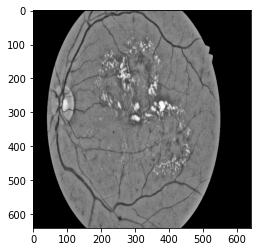

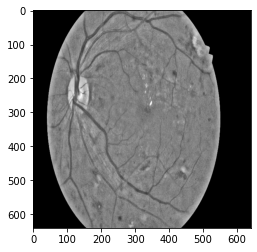

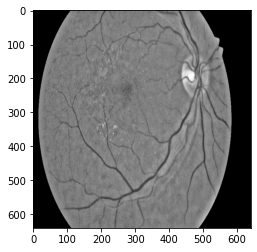

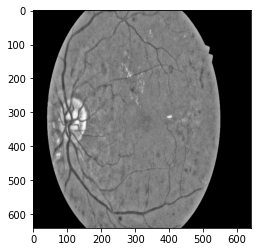

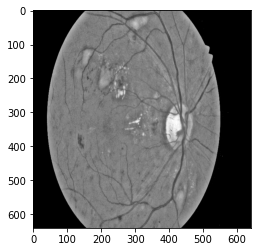

In [16]:
for i in range(5):
  plt.imshow(test_batch[i,:,:,3],cmap='gray')
  plt.show()

In [ ]:
predicted_test_label=np.zeros(test_label.shape)
for i in range(27):
  #print(np.expand_dims(test_batch[i],axis=0).shape)
  predicted_test_label[i]=models[0].predict(np.expand_dims(test_batch[i],axis=0)) 

2 layers  24 filter
train  0  test roc 0.7841826312507536
Train  F1 score: 0.000000 Test F1 score: 0.390357
Accuracy: 0.998976
natural threshold train AUPR 0  test AUPR 0.28300156392824766


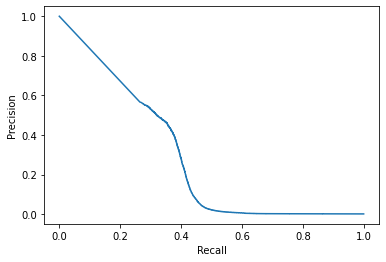

In [21]:
#for j,model in enumerate(models):
print(2, "layers ",24,"filter")
predicted_test_label=np.zeros(test_label.shape)
for i in range(27):
#print(np.expand_dims(test_batch[i],axis=0).shape)
  predicted_test_label[i]=model.predict(np.expand_dims(test_batch[i],axis=0))
#generate the masks

#predicted_test_label=model.predict(test_batch)

# ROC
test_auc = roc_auc_score(test_label[0:27,:,:,:].reshape(-1),predicted_test_label.reshape(-1))
#train_auc = roc_auc_score(train_label.reshape(-1),predicted_train_label.reshape(-1))
print("train ",0," test roc",test_auc)

# F1
testy, yhat_classes=(test_label[0:27,:,:,:].reshape(-1),np.round(predicted_test_label.reshape(-1)))
test_f1 = f1_score(testy, yhat_classes)
#testy, yhat_classes=train_label.reshape(-1),np.round(predicted_train_label.reshape(-1))
#train_f1 = f1_score(testy, yhat_classes)
train_f1=0
print('Train  F1 score: %f' % train_f1,'Test F1 score: %f' % test_f1)

#accuracy
accuracy = accuracy_score(testy, yhat_classes)
print('Accuracy: %f' % accuracy)
#AUPR

test_aupr = precision_recall_curve(test_label[0:27,:,:,:].reshape(-1),predicted_test_label.reshape(-1))
train_auc=0
test_auc=auc(test_aupr[1],test_aupr[0] )
print("natural threshold train AUPR",train_auc," test AUPR",test_auc)

#plot Precision recall curve
plt.plot(test_aupr[1],test_aupr[0])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()
#del predicted_test_label 

(640, 640, 1)


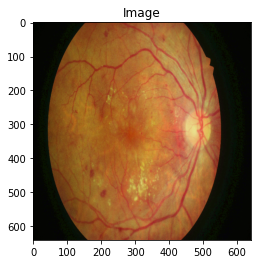

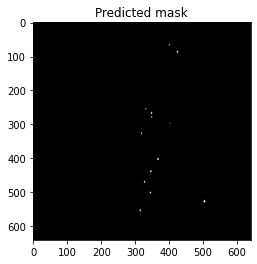

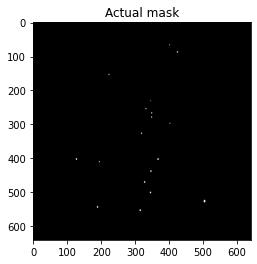

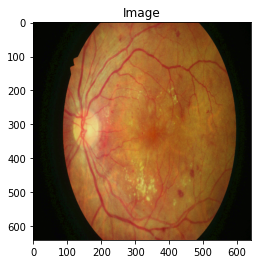

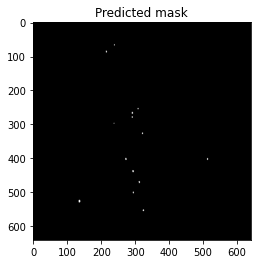

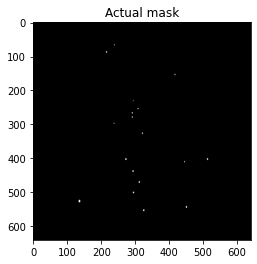

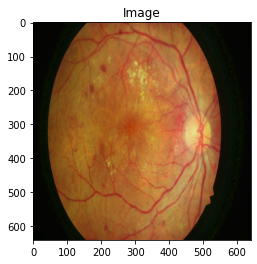

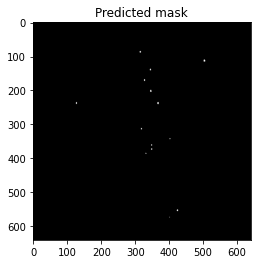

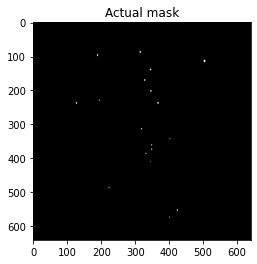

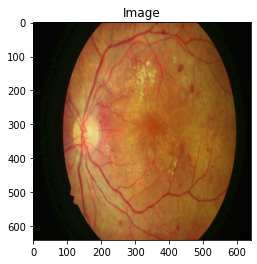

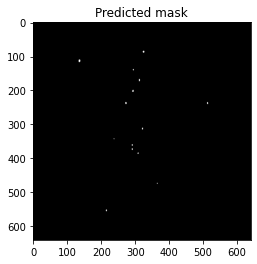

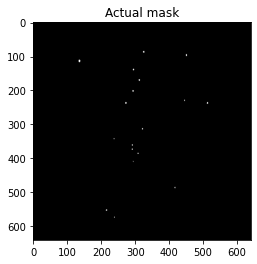

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


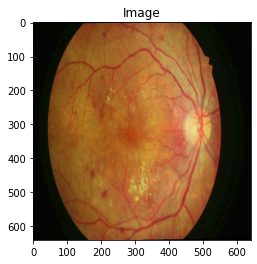

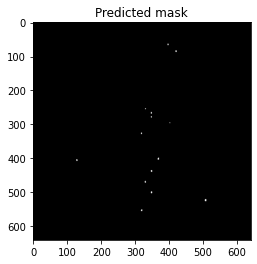

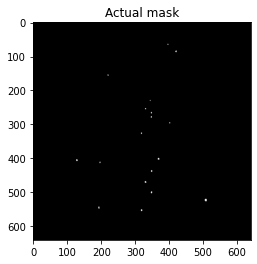

In [20]:
print(predicted_test_label[0].shape)
for i in range(5):
    plt.imshow(train_batch[i,:,:,0:3])
    plt.title("Image")
    plt.show()  
    plt.imshow(np.squeeze(predicted_test_label[i,:,:,:], axis = 2),cmap='gray')
    plt.title("Predicted mask")
    plt.show()
    plt.imshow(np.squeeze(train_label[i,:,:,:], axis = 2), cmap='gray')
    plt.title("Actual mask")
    plt.show()